In [1]:
from lib.load import *
from lib.dataset import *
from lib.thumbnail import *
from lib.globals import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle

In [2]:
all_train_img_names, test_img_names = load()

In [3]:
# Get mask thumbnail dictionary
thumbnail_filename = "./data/thumbnails_" + str(PATCH_WIDTH*3) + "x" + str(PATCH_HEIGHT*3) + ".p"
if not os.path.exists(thumbnail_filename):
    create_thumbnails(PATCH_WIDTH*3, PATCH_HEIGHT*3)

In [4]:
with open(thumbnail_filename, "rb") as fp:
    thumbnails_dict = pickle.load(fp)

print(len(thumbnails_dict))

10516


In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print(DEVICE)
# # determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

# partition the data into training and validation splits using 85% of
# the data for training and the remaining 15% for validation
split_size = math.floor(VAL_SPLIT*len(all_train_img_names))
split = torch.utils.data.random_split(all_train_img_names,
                                    [split_size, len(all_train_img_names)-split_size], 
                                    generator=torch.Generator().manual_seed(42))

# unpack the data split
(train_img_names, val_img_names) = split
train_img_names = list(train_img_names)
val_img_names = list(val_img_names)
# print(train_img_names[:10])
# print(val_img_names[:10])

# create the train and validation datasets
trainDS = SegmentationDataset(wsi_names=train_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=NUM_PSEUDO_EPOCHS)
valDS = SegmentationDataset(wsi_names=val_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=NUM_PSEUDO_EPOCHS)
print(f"[INFO] found {len(trainDS)} samples in the training set...")
print(f"[INFO] found {len(valDS)} samples in the validation set...")

# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=4)
valLoader = DataLoader(valDS, shuffle=False,
    batch_size=BATCH_SIZE, num_workers=4)

Make Slide Dict: 100%|██████████| 774/774 [00:00<00:00, 1152.26it/s]


[INFO] found 1024 samples in the training set...
[INFO] found 1024 samples in the validation set...


In [ ]:
# list(thumbnails_dict.keys())

In [6]:
accumulated = torch.empty(0, dtype=torch.int8)
for e in tqdm(range(30)):
    # loop over the training set
    for (x, y) in trainLoader:
        accumulated = torch.cat((accumulated,y.flatten()))
        # print(y.flatten())
        # print(torch.bincount(y.flatten()))

print(accumulated)
counts = torch.bincount(accumulated)
print(counts)

100%|██████████| 30/30 [03:58<00:00,  7.94s/it]


tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int16)
tensor([1689398370,  275356200,   16449120,   11635650,   17844810,    2581770])


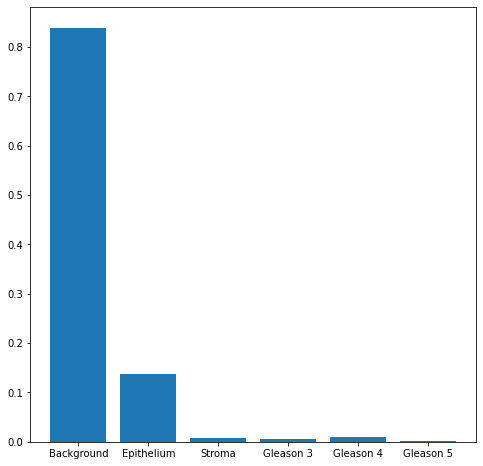

In [7]:
total = torch.sum(counts)

figure, ax = plt.subplots(1,1,figsize=(8,8))
x = np.arange(len(counts))

labels = ["Background", "Epithelium", "Stroma", "Gleason 3", "Gleason 4", "Gleason 5"]

ax.bar(x,counts/total)
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()